# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Solución

In [0]:
# Imports
import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## Carga de datos

### Precios


In [0]:
urlPrecios = 'https://github.com/ANN-2019-2/evaluacion-edalpin/blob/master/datos/precios/Precio_Bolsa_Nacional_($kwh)_'
extension = '.xlsx?raw=true'
lista = []
omitirPrecios = 3

for y in range(1995, 2019):
  if y > 2015:
    extension = '.xls?raw=true'
  if y > 1999:
    omitirPrecios = 2
  url = urlPrecios + str(y) + extension
  data = pd.read_excel(url, skiprows=omitirPrecios, header=0)
  lista.append(data)

dataFramePrecios = lista[0]
for elemento in lista[1:]:
    dataFramePrecios = dataFramePrecios.append(elemento, sort=True)

dataFramePrecios = dataFramePrecios.dropna(subset=['Fecha'])

In [3]:
dataFramePrecios.head(5)

,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,3,4,5,6,7,8,9,Fecha,Version,NaN,Unnamed: 26
0,NaN,1.073,2.827,2.827,2.827,1.074,1.073,1.073,1.073,1.073,1.074,1.897,1.073,1.897,1.897,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,1.074,1995-07-20,NaN,NaN,NaN
1,1.073,1.000,6.000,9.256,9.256,5.000,5.000,1.000,1.000,5.000,12.000,16.670,1.000,11.929,5.000,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,6.000,1995-07-21,NaN,NaN,NaN
2,1.073,1.073,1.303,1.303,1.303,1.303,1.073,1.000,1.000,1.000,1.303,2.500,1.000,2.500,1.303,1.073,1.073,1.000,1.000,1.073,1.303,1.303,1.303,1.303,1995-07-22,NaN,NaN,NaN
3,1.073,1.000,1.000,1.000,1.238,1.238,1.000,0.100,0.100,1.000,1.238,1.238,1.000,1.238,1.238,1.073,1.000,1.000,1.000,1.000,0.100,1.000,1.000,1.000,1995-07-23,NaN,NaN,NaN
4,1.000,1.000,8.845,9.256,3.000,1.073,1.073,1.073,3.000,2.000,18.630,22.500,0.990,9.256,3.000,1.073,1.000,1.000,1.000,1.073,3.000,3.000,3.000,3.500,1995-07-24,NaN,NaN,NaN


### IPC


In [0]:
urlIPC = 'https://github.com/ANN-2019-2/evaluacion-edalpin/blob/master/datos/1.2.5.IPC_Serie_variaciones.xlsx?raw=true'
omitirIPC = 12
dataFrameIPC = pd.read_excel(urlIPC,skiprows=omitirIPC,header=0,nrows=320)

In [5]:
dataFrameIPC.head(5)

,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido
0,202002,104.94,0.0372,0.0067,0.0109
1,202001,104.24,0.0362,0.0042,0.0042
2,201912,103.80,0.0380,0.0026,0.0380
3,201911,103.54,0.0384,0.0010,0.0354
4,201910,103.43,0.0386,0.0016,0.0343


## Modificación de los datos previamente cargados

### Cálculo del precio promedio de la energia por día

Obtenemos el promedio diario del precio de la energia

In [0]:
def obtenerPromedioDiario(fila):
  acumulado = 0
  total = 24
  for i in range(24):
    if(math.isnan(fila[str(i)])):
      total-=1
    else:
      acumulado+=fila[str(i)]
  acumulado=acumulado/total
  return(acumulado)

dataFramePrecios['Promedio'] = dataFramePrecios.apply(obtenerPromedioDiario, axis=1)

Eliminamos las columnas que no necesitamos para el proceso y apregamos el tipo a la fecha para graficar la data.

In [7]:
dataFramePrecios = dataFramePrecios[['Fecha','Promedio']].copy()
dataFramePrecios["Fecha"] = pd.to_datetime(dataFramePrecios["Fecha"])
dataFramePrecios.head(3)

,Fecha,Promedio
0,1995-07-20,1.409435
1,1995-07-21,4.924333
2,1995-07-22,1.269500


Graficamos la distribución de los datos

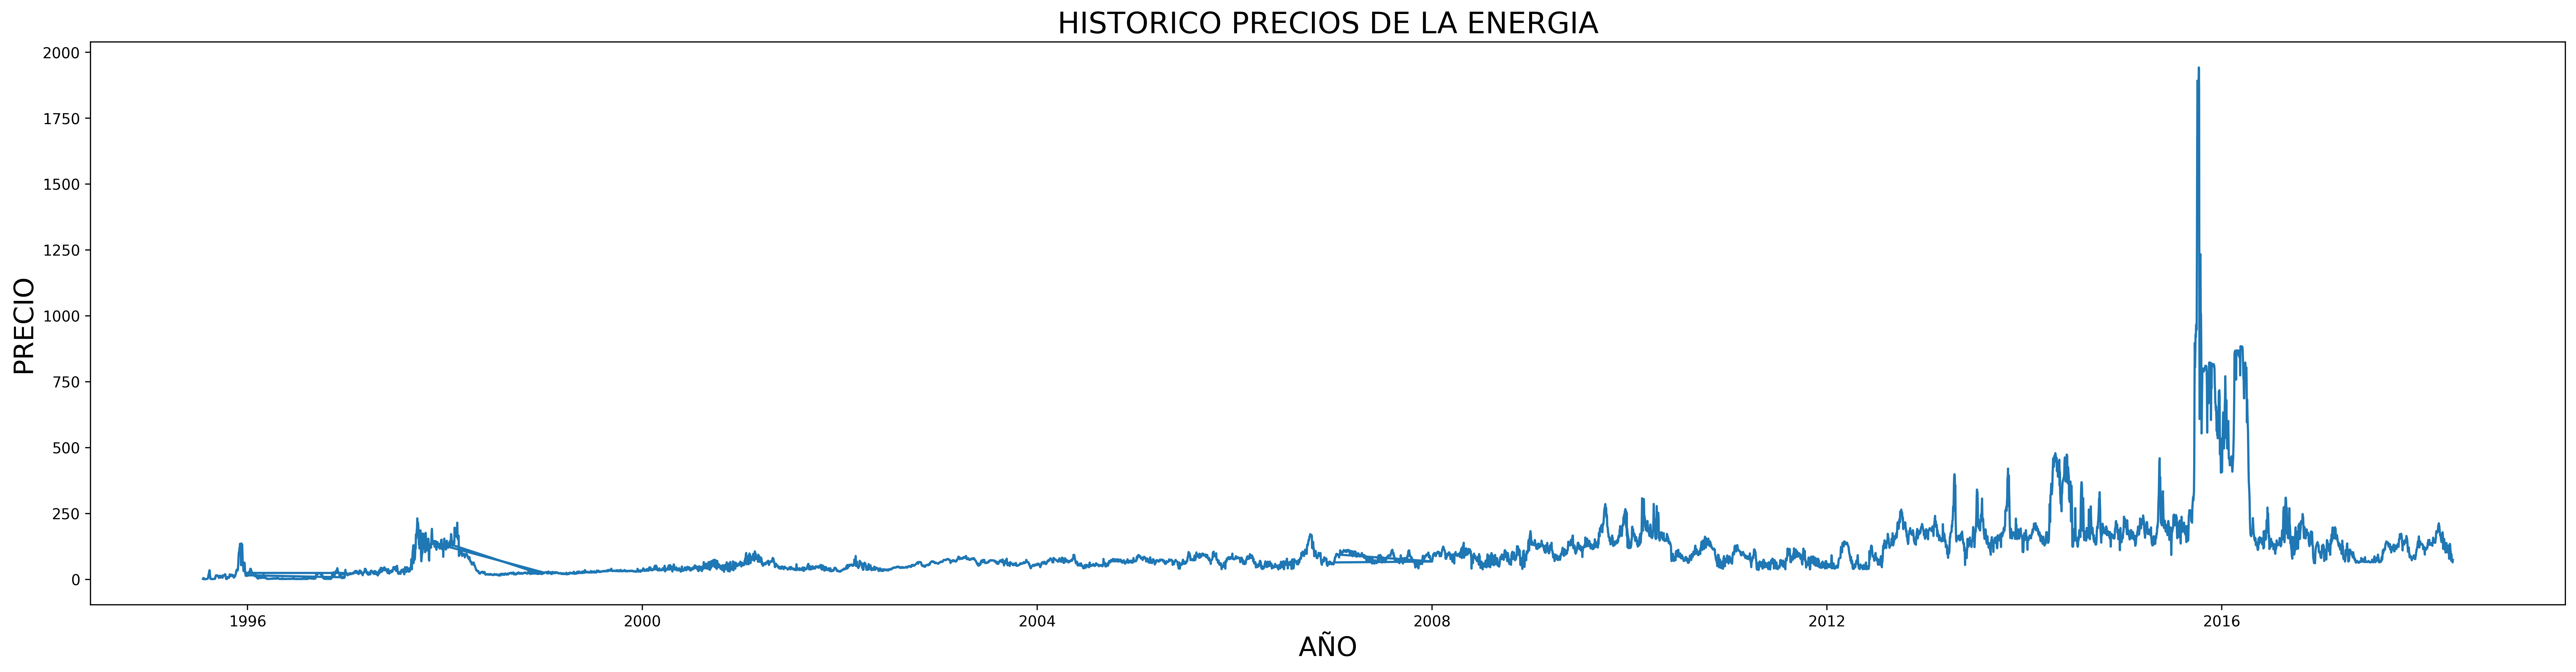

In [8]:
figure(num=None, figsize=(30,7), dpi=320, facecolor='w', edgecolor='g')
plt.plot(dataFramePrecios["Fecha"], dataFramePrecios["Promedio"])
plt.title('HISTORICO PRECIOS DE LA ENERGIA', fontsize=20)
plt.xlabel('AÑO', fontsize=18)
plt.ylabel('PRECIO', fontsize=18)
plt.show()

### Parseo de fechas para mantener consistencia entre formatos

Precios

In [0]:
def obtenerAnoPrecio(fila):
    return(str(fila['Fecha'])[0:4])

def obtenerMesPrecio(fila):
    return(str(fila['Fecha'])[5:7])

dataFramePrecios['ano']=dataFramePrecios.apply(obtenerAnoPrecio, axis=1)
dataFramePrecios['mes']=dataFramePrecios.apply(obtenerMesPrecio, axis=1)

In [10]:
dataFramePrecios.head(3)

,Fecha,Promedio,ano,mes
0,1995-07-20,1.409435,1995,07
1,1995-07-21,4.924333,1995,07
2,1995-07-22,1.269500,1995,07


IPC

In [0]:
def obtenerAnoIPC(fila):
    return(str(fila['Año(aaaa)-Mes(mm)'])[0:4])

def obtenerMesIPC(fila):
    return(str(fila['Año(aaaa)-Mes(mm)'])[4:6])

dataFrameIPC['ano']=dataFrameIPC.apply(obtenerAnoIPC, axis=1)
dataFrameIPC['mes']=dataFrameIPC.apply(obtenerMesIPC, axis=1)

In [12]:
dataFrameIPC.head(3)

,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido,ano,mes
0,202002,104.94,0.0372,0.0067,0.0109,2020,02
1,202001,104.24,0.0362,0.0042,0.0042,2020,01
2,201912,103.80,0.0380,0.0026,0.0380,2019,12


### Mezcla de los dataframes


In [0]:
dataFrame = dataFramePrecios.merge(dataFrameIPC, on=['ano','mes'],how='left')
maxIndice=dataFrame.max()['Índice']


Estandarizar el precio promedio

In [0]:
def estandarizarPrecio(fila, maxIndice):
    nuevo =fila['Promedio']*float(maxIndice)/float(fila['Índice'])
    return(nuevo)

dataFrame['PromedioNormalizado'] = dataFrame.apply(estandarizarPrecio, axis=1, args=[maxIndice])

Borramos las columnas que no usaremos del dataframe resultante

In [0]:
dataFrame = dataFrame.drop(['ano','mes','Año(aaaa)-Mes(mm)','Índice','Inflación anual','Inflación mensual','Inflación año corrido'],axis=1)

In [16]:
dataFrame.head(3)

,Fecha,Promedio,PromedioNormalizado
0,1995-07-20,1.409435,6.677475
1,1995-07-21,4.924333,23.330000
2,1995-07-22,1.269500,6.014506


### Gráfica de comparación de precios

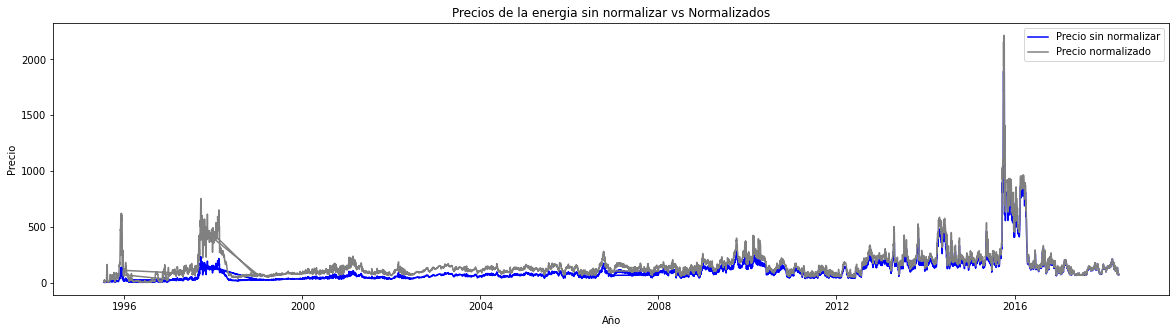

In [17]:
plt.figure(figsize=(20,5))
plt.title('Precios de la energia sin normalizar vs Normalizados')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.plot(dataFrame['Fecha'], dataFrame['Promedio'],label="Precio sin normalizar", color='blue')
plt.plot(dataFrame['Fecha'], dataFrame['PromedioNormalizado'],label="Precio normalizado", color='gray')
plt.legend()
plt.show()

## Modelo

### Transformaciones

Transformaciones a aplicar:
*   Cuadratica
*   Logaritmica
*   Raiz cuadrada
*   Identidad

In [0]:
transformaciones = [
  ("Función Cuadratica", lambda x : np.power(x, 2)),
  ("Función Logaritmica", lambda x : np.log(x)),
  ("Función raiz cuadrada", lambda x : np.power(x, 1/2)),
  ("Función Identidad", lambda x : x)
]

transformacionesInversas = {
  "Función Cuadratica": lambda x : np.power(x, 1/2),
  "Función Logaritmica": lambda x : np.exp(x),
  "Función raiz cuadrada": lambda x : np.power(x, 2),
  "Función Identidad": lambda x : x
}

### Adaline

In [0]:
class Adaline:
  def __init__(self,
                momentum=0.5,
                learning_rate=0.001, # tasa de aprendizaje
                max_epochs=1,        # número máximo de iteraciones sobre el set de datos
                random_state=24,   #
                warm_start=False):   #
      
    self.momentum = momentum
    self.learning_rate = learning_rate
    self.max_epochs = max_epochs
    self.random_state = random_state
    self.warm_start = warm_start
    self.coef_ = None
    self.intercept_ = None

  def fit(self, X, y):
    if not isinstance(X, np.ndarray):
      X = np.array(X)
        
    if not isinstance(y, np.ndarray):
      d = np.array(y)
    else:
      d = y.copy()

    if self.random_state is not None:
      np.random.RandomState(self.random_state)

    if self.coef_ is None or self.warm_start is False:
      self.coef_ = np.random.uniform(-1, 1, X.shape[1])

    if self.intercept_ is None  or self.warm_start is False:
      self.intercept_ = np.random.uniform(-1, 1, 1)

    errors2 = []
    forecasts = []
    vintercepto = 0     
    v = 0               

    for i in range(X.shape[0]):
      u = np.dot(X[i,:], self.coef_) + self.intercept_
      e = (d[i] - u)[0]
      v = self.momentum * v + self.learning_rate * (e / abs(e)) * X[i,:]
      self.coef_ += v
      vintercepto = self.momentum * vintercepto + self.learning_rate * (e / abs(e)) 
      self.intercept_ += vintercepto
      errors2.append(e**2)
      forecasts.append(u)

    mse = (mean_squared_error(y, forecasts))
    mae = (mean_absolute_error(y, forecasts))
    return mse, mae

  def predict(self, X):
    if not isinstance(X, np.ndarray):
      X = np.array(X)
    u = np.dot(X, self.coef_) + self.intercept_
    return u

### Ejecución del modelo con las diferentes transformaciones

In [0]:
dataFrameEntrenamiento = dataFrame['PromedioNormalizado'][:-7]
dataFramePrueba = dataFrame['PromedioNormalizado'][-7:]

learningRates = np.arange(0.01, 0.1, 0.01).tolist()
momentums =  np.arange(0.01, 0.1, 0.01).tolist()

llaves = []
msesEntrenamiento = []
maesEntrenamiento  = []
msesValidacion = []
maesValidacion  = []

def normalizar(data, min, max):
  arrayNormalizado = []
  for i in data:
    arrayNormalizado.append((i - min) / (max - min))
  return pd.Series(arrayNormalizado)

def denormalizar(data, min, max):
  arrayDenormalizado = []
  for i in data:
    arrayDenormalizado.append((i *(max - min)) + min)
  return pd.Series(arrayDenormalizado)

# Ciclo transformaciones
for nombreTrans, trans in transformaciones:
  ## Aplicamos la transformación al set de entrenamiento previamente
  dataFrameEntrenamientoT = dataFrameEntrenamiento.copy().apply(trans)

  ## Normalizamos los datos a una escala de 0, 1
  minValue = min(dataFrameEntrenamientoT)
  maxValue = max(dataFrameEntrenamientoT)
  dataFrameEntrenamientoT = normalizar(dataFrameEntrenamientoT.copy(), minValue, maxValue)

  # Ciclo momentums
  for mt in momentums:

    # Ciclo tasa de aprendizajes
    for lr in learningRates:

      # Ciclo retardos
      for nRetardos in range(7, 12):
        llaves.append(str(nombreTrans) + ' ' +  # Transformación
                      str(nRetardos) + ' ' +    # Retardos
                      str(lr) + ' ' +           # Tasa de aprendizaje
                      str(mt))                  # Momentum

        modelo = Adaline(momentum=mt, learning_rate=lr)

        ## Entrenamiento
        X = []
        y = []
        ## Conjuntos de datos del tamaño de n retardos (días desde hacia atras)
        for iRetardo in range(nRetardos, len(dataFrameEntrenamientoT)):
          X.append(dataFrameEntrenamientoT[iRetardo-nRetardos:iRetardo].copy())

        y = dataFrameEntrenamientoT[nRetardos:].copy()

        mse, mae = modelo.fit(X,y)
        msesEntrenamiento.append(mse)
        maesEntrenamiento.append(mae)

        ## Predicción de los siguientes n días
        XPred = X[-1].copy()
        for dia in range(len(dataFramePrueba)):
          XPred = XPred[1:].append(pd.DataFrame(modelo.predict(XPred))[0])

        ## Para poder calcular los errores entre datos que tienen la misma transformación

        ## Denormalizamos los datos a su escala original
        dataPredichaT = denormalizar(XPred[0].copy(), minValue, maxValue)

        ## Aplicamos la transformación inversa al set de prueba seleccionado previamente
        dataPredichaT = dataPredichaT.copy().apply(transformacionesInversas[nombreTrans])

        ## Calculamos el error de los datos
        try:
          msesValidacion.append(mean_squared_error(dataFramePrueba, dataPredichaT))
          maesValidacion.append(mean_absolute_error(dataFramePrueba, dataPredichaT))
        except:
          msesValidacion.append(math.inf)
          maesValidacion.append(math.inf)

### Gráficas de los errores de entrenamiento y predicción

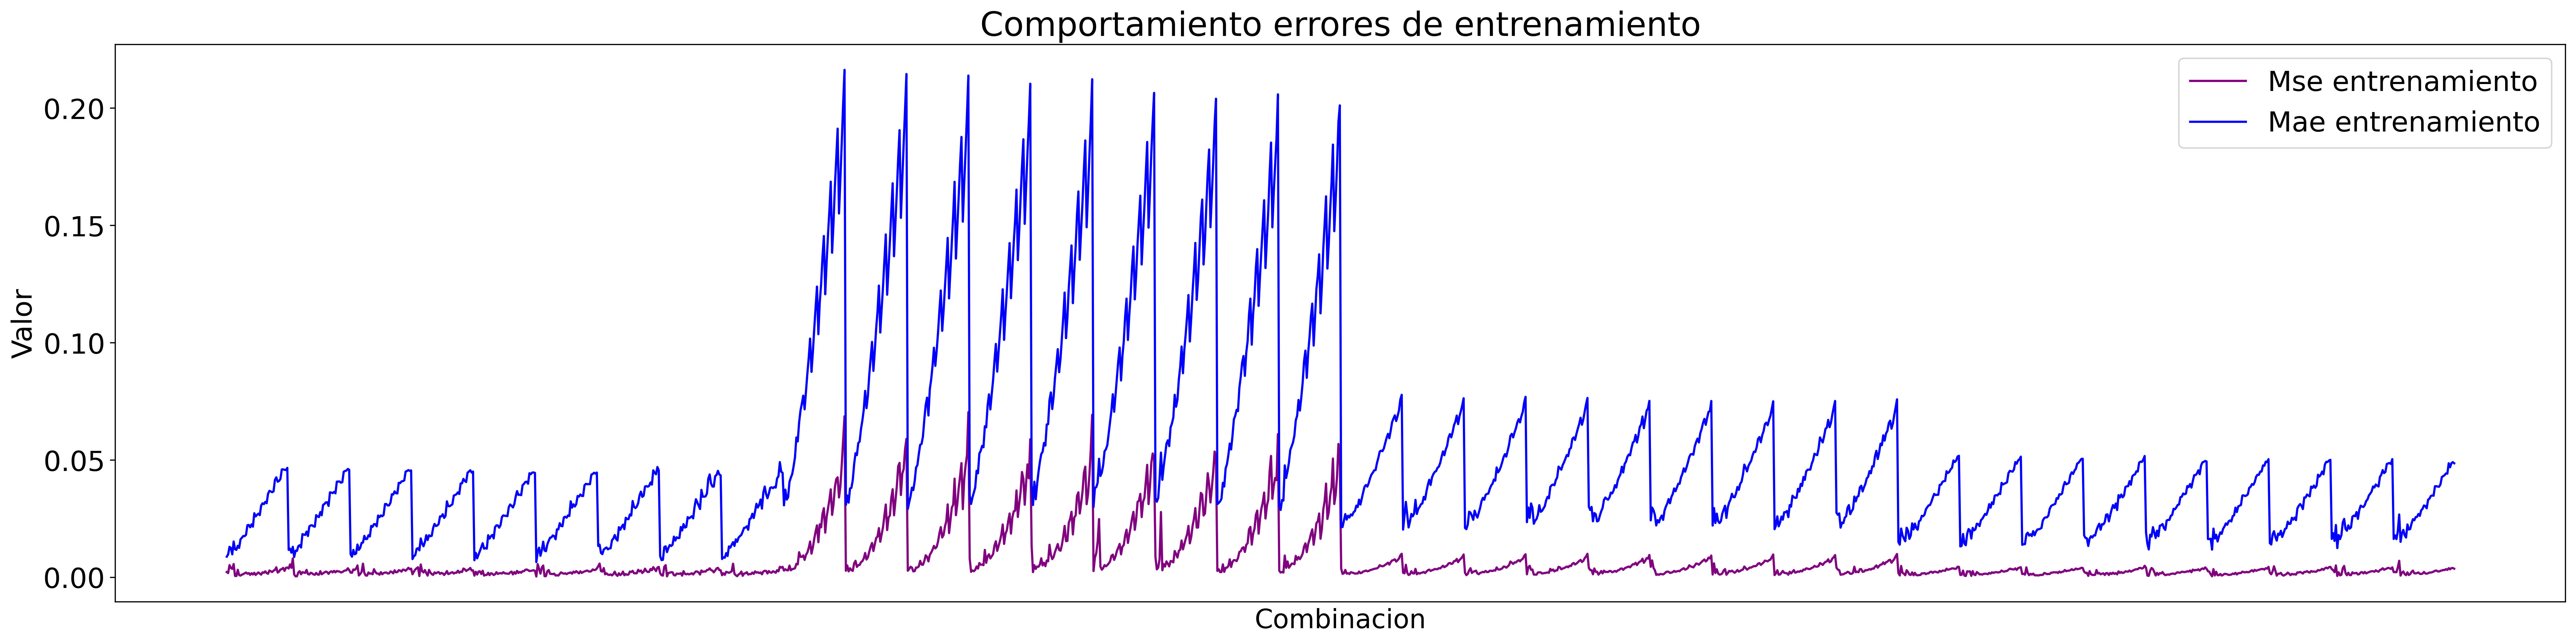

In [21]:
figure(num=None, figsize=(30,7), dpi=320, facecolor='w', edgecolor='g')
plt.rcParams.update({'font.size': 19})
plt.plot(llaves,
         msesEntrenamiento,
         label="Mse entrenamiento",
         color='purple')

plt.plot(llaves,
         maesEntrenamiento,
         label="Mae entrenamiento",
         color='blue')

plt.xlabel('Combinacion', fontsize=18)
plt.ylabel('Valor')
plt.title('Comportamiento errores de entrenamiento')
plt.xticks([])
plt.legend()
plt.show()

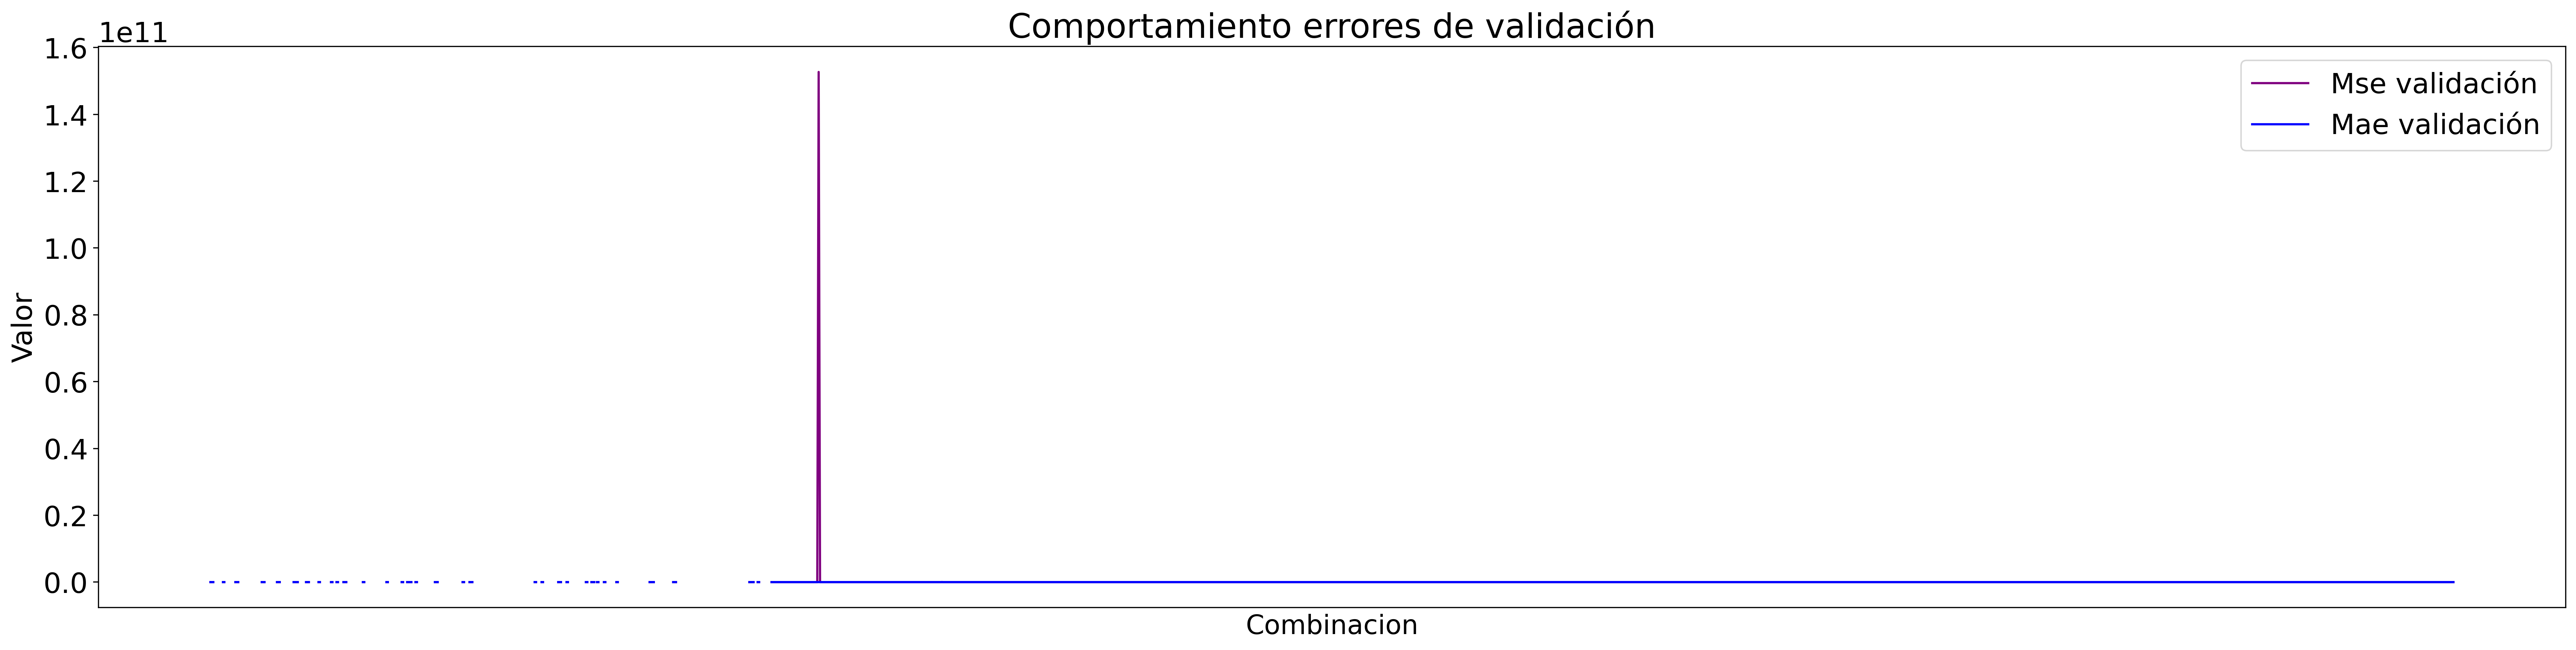

In [22]:
figure(num=None, figsize=(30,7), dpi=320, facecolor='w', edgecolor='g')
plt.rcParams.update({'font.size': 19})
plt.plot(llaves,
         msesValidacion,
         label="Mse validación",
         color='purple')

plt.plot(llaves,
         maesValidacion,
         label="Mae validación",
         color='blue')

plt.xlabel('Combinacion', fontsize=18)
plt.ylabel('Valor')
plt.title('Comportamiento errores de validación')
plt.xticks([])
plt.legend()
plt.show()

### Resultados

Las gráficas presentadas anteriormente muestran el comportamiento de los errores de todos los modelos evaluados lo cual genera muy poca visivilidad en el comportamiento de los mejores modelos (menor error), por lo cual sacaremos un subset con los mejores 100 modelos para graficar su comportamiento

In [0]:
x = np.arange(0, 100, 1).tolist()
mejoresModelosMse = sorted(msesValidacion)[:100]
mejoresModelosMae = sorted(maesValidacion)[:100]

#### Resultados MSE

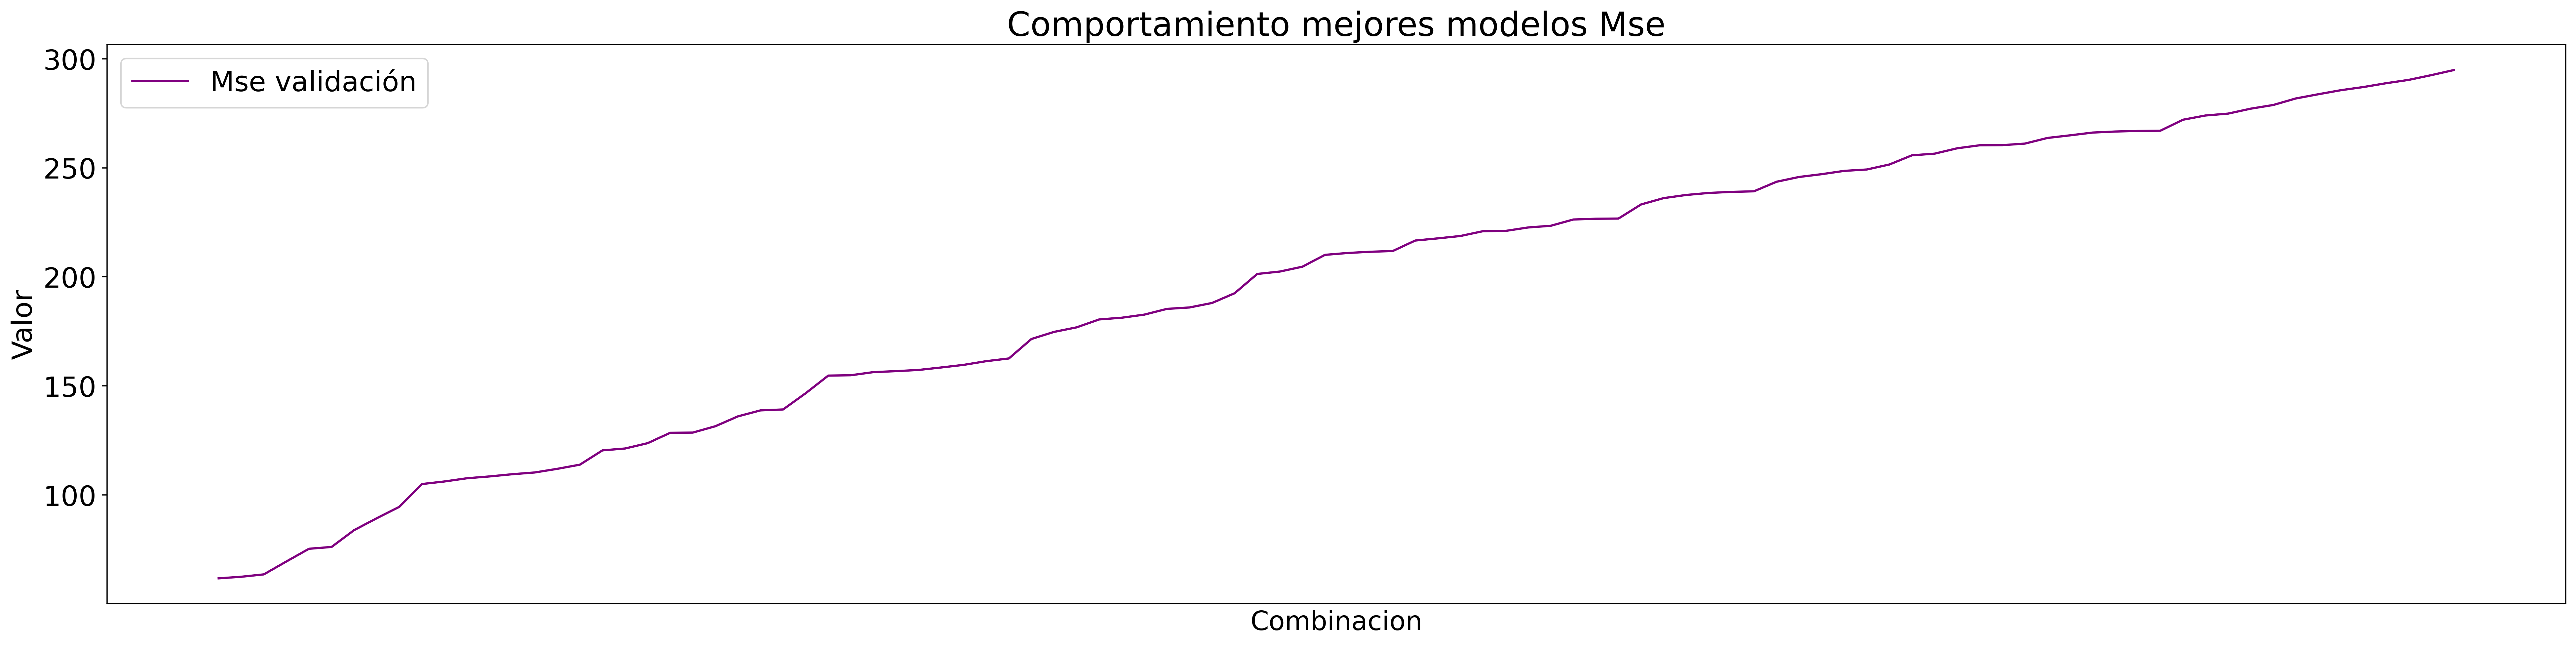

In [44]:
figure(num=None, figsize=(30,7), dpi=320, facecolor='w', edgecolor='g')
plt.rcParams.update({'font.size': 19})
plt.plot(x,
         mejoresModelosMse,
         label="Mse validación",
         color='purple')
plt.xlabel('Combinacion', fontsize=18)
plt.ylabel('Valor')
plt.title('Comportamiento mejores modelos Mse')
plt.xticks([])
plt.legend()
plt.show()

El menor error (MSE) reportado en la predicción se genera con la siguiente combinación:

Nota: el formato del resultado es el siguiente:

*Transformacion - Retardos - Tasa de aprendizaje - Momentum*

In [23]:
print(llaves[msesValidacion.index(min(msesValidacion))])

Función Logaritmica 7 0.03 0.01


#### Resultados MAE

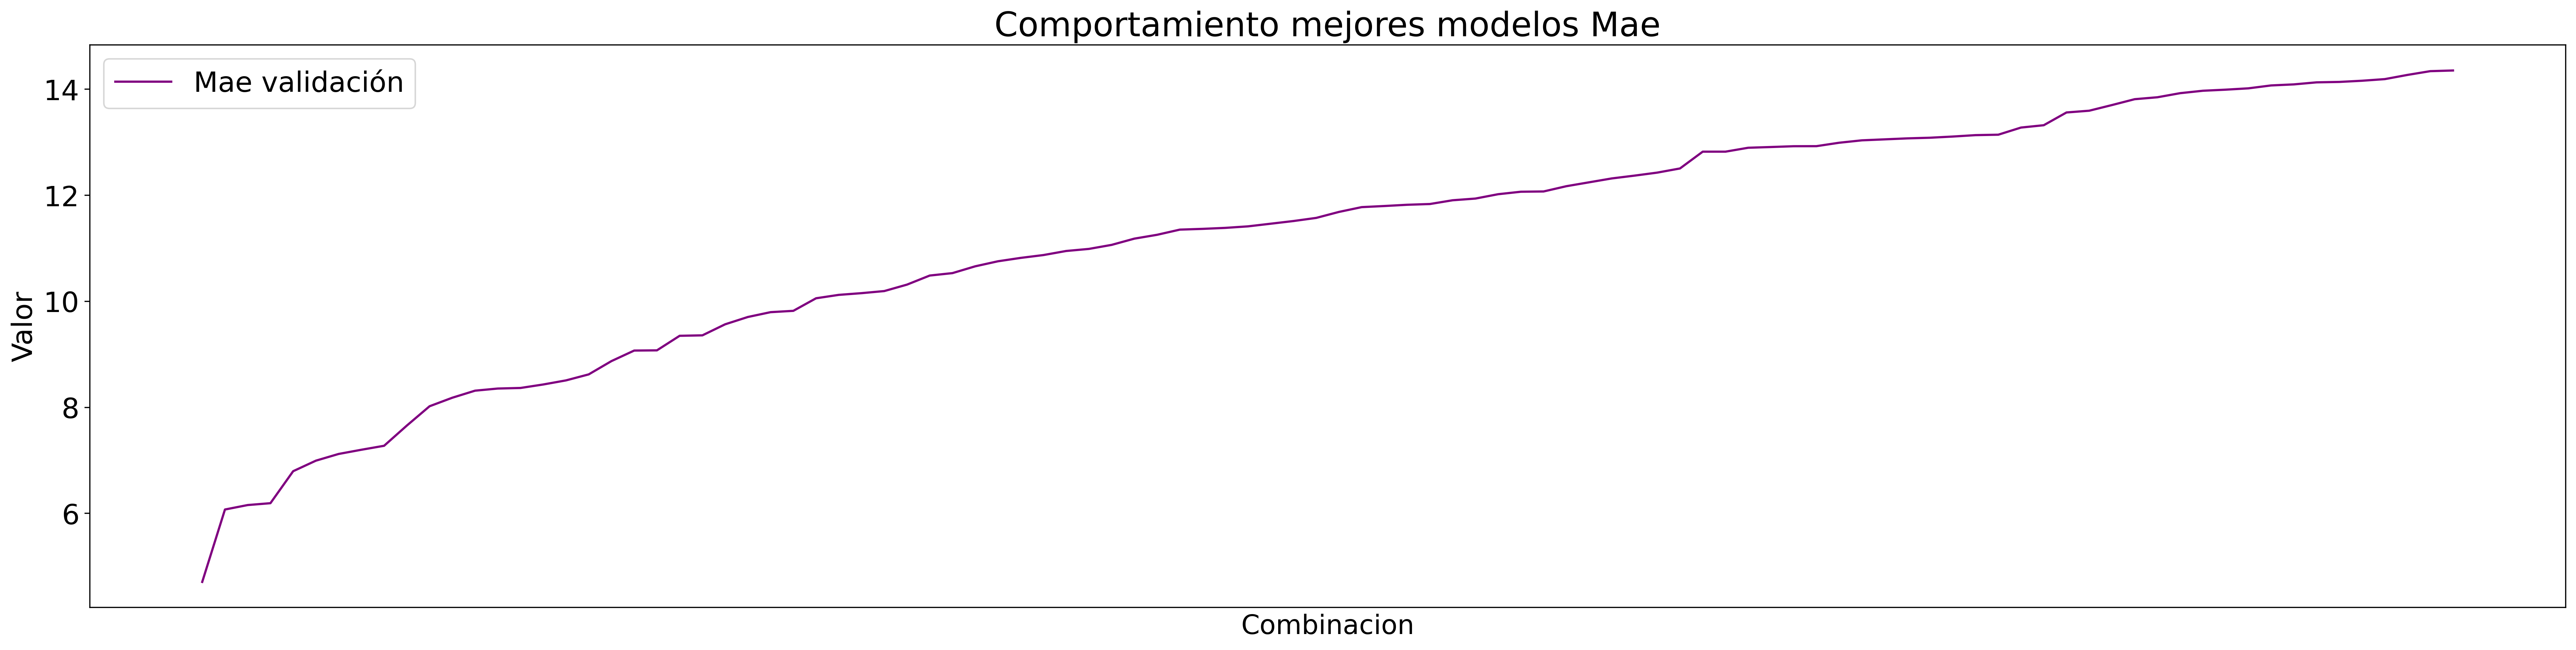

In [46]:
figure(num=None, figsize=(30,7), dpi=320, facecolor='w', edgecolor='g')
plt.rcParams.update({'font.size': 19})
plt.plot(x,
         mejoresModelosMae,
         label="Mae validación",
         color='purple')
plt.xlabel('Combinacion', fontsize=18)
plt.ylabel('Valor')
plt.title('Comportamiento mejores modelos Mae')
plt.xticks([])
plt.legend()
plt.show()

El menor error (MAE) reportado en la predicción se genera con la siguiente combinación:

Nota: el formato del resultado es el siguiente:

*Transformacion - Retardos - Tasa de aprendizaje - Momentum*

In [47]:
print(llaves[maesValidacion.index(min(maesValidacion))])

Función raiz cuadrada 9 0.08 0.08


# Conclusión

El modelo que mejor predice basandonos en el menor **MSE** tiene la siguiente configuración:

* **Transformación**: Logaritmo.
* **Rezagos**: 7.
* **Learning_rate**: 0.03.
* **Momentum**: 0.01.


El modelo que mejor predice basandonos en el menor **MAE** tiene la siguiente configuración:

* **Transformación**: Raíz cuadrada.
* **Rezagos**: 9.
* **Learning_rate**: 0.08.
* **Momentum**: 0.08.